In [1]:
!git clone https://github.com/rightlit/StackGAN-v2-rev
%cd StackGAN-v2-rev

Cloning into 'StackGAN-v2-rev'...
remote: Enumerating objects: 828, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 828 (delta 30), reused 68 (delta 1), pack-reused 711 (from 1)
Receiving objects: 100% (828/828), 171.13 MiB | 34.23 MiB/s, done.
Resolving deltas: 100% (80/80), done.
/content/StackGAN-v2-rev


In [14]:
import sys
sys.path.append('./')

In [16]:
!pip install tensorboardX==1.1 python-dateutil easydict pandas torchfile

birds.zip ---> data/

In [4]:
from google.colab import files
uploaded = files.upload()         # birds.zip

Saving birds.zip to birds.zip


In [13]:
# birds.zip to data/
import shutil
shutil.move('/content/StackGAN-v2-rev/birds.zip', '/content/StackGAN-v2-rev/data/birds.zip')

FileNotFoundError: [Errno 2] No such file or directory: '/content/StackGAN-v2-rev/birds.zip'

In [11]:
import zipfile

zip_path = '/content/StackGAN-v2-rev/data/birds.zip'
extract_path = '/content/StackGAN-v2-rev/data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

CUB_200_2011.tgz ---> data/bird

In [26]:
uploaded = files.upload()    # CUB_200_2011.tgz

Saving CUB_200_2011.tgz to CUB_200_2011.tgz
tar: data/birds: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [27]:
!tar -xvzf CUB_200_2011.tgz -C /content/StackGAN-v2-rev/data/birds

Görüntülenen çıkış son 5000 satıra kısaltıldı.
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0050_111087.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0079_113288.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0004_111989.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0068_113247.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0127_111935.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0094_112773.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0028_113217.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0126_110959.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0007_111029.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0096_111519.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0120_113001.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0010_112678.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0025_111669.jpg
CUB_200_2011/images/118.House_Sparrow/House_Sparrow_0084_111300.jpg
C

In [21]:
# fix config.py

fixed_config = """
from __future__ import division
from __future__ import print_function

import os.path as osp
import numpy as np
from easydict import EasyDict as edict


__C = edict()
cfg = __C

# Dataset name: flowers, birds
__C.DATASET_NAME = 'birds'
__C.EMBEDDING_TYPE = 'cnn-rnn'
__C.CONFIG_NAME = ''
__C.DATA_DIR = ''

__C.GPU_ID = '0'
__C.CUDA = True

__C.WORKERS = 6

__C.TREE = edict()
__C.TREE.BRANCH_NUM = 3
__C.TREE.BASE_SIZE = 64


# Test options
__C.TEST = edict()
__C.TEST.B_EXAMPLE = True
__C.TEST.SAMPLE_NUM = 30000


# Training options
__C.TRAIN = edict()
__C.TRAIN.BATCH_SIZE = 64
__C.TRAIN.VIS_COUNT = 64
__C.TRAIN.MAX_EPOCH = 600
__C.TRAIN.SNAPSHOT_INTERVAL = 2000
__C.TRAIN.DISCRIMINATOR_LR = 2e-4
__C.TRAIN.GENERATOR_LR = 2e-4
__C.TRAIN.FLAG = True
__C.TRAIN.NET_G = ''
__C.TRAIN.NET_D = ''

__C.TRAIN.COEFF = edict()
__C.TRAIN.COEFF.KL = 2.0
__C.TRAIN.COEFF.UNCOND_LOSS = 0.0
__C.TRAIN.COEFF.COLOR_LOSS = 0.0


# Modal options
__C.GAN = edict()
__C.GAN.EMBEDDING_DIM = 128
__C.GAN.DF_DIM = 64
__C.GAN.GF_DIM = 64
__C.GAN.Z_DIM = 100
__C.GAN.NETWORK_TYPE = 'default'
__C.GAN.R_NUM = 2
__C.GAN.B_CONDITION = False

__C.TEXT = edict()
__C.TEXT.DIMENSION = 1024


def _merge_a_into_b(a, b):
    if type(a) is not edict:
        return

    for k, v in a.items():  # Changed from iteritems() to items()
        # a must specify keys that are in b
        if k not in b:  # Changed from has_key() to 'in' operator
            raise KeyError('{} is not a valid config key'.format(k))

        # the types must match, too
        old_type = type(b[k])
        if old_type is not type(v):
            if isinstance(b[k], np.ndarray):
                v = np.array(v, dtype=b[k].dtype)
            else:
                raise ValueError(('Type mismatch ({} vs. {}) '
                                  'for config key: {}').format(type(b[k]),
                                                               type(v), k))

        # recursively merge dicts
        if type(v) is edict:
            try:
                _merge_a_into_b(a[k], b[k])
            except:
                print('Error under config key: {}'.format(k))
                raise
        else:
            b[k] = v


def cfg_from_file(filename):
    import yaml
    with open(filename, 'r') as f:
        yaml_cfg = edict(yaml.safe_load(f))  # Changed from yaml.load() to yaml.safe_load()

    _merge_a_into_b(yaml_cfg, __C)
"""
with open("/content/StackGAN-v2-rev/code/miscc/config.py", "w") as f:
    f.write(fixed_config)

In [23]:
# fix main.py

main_py_text = """
from __future__ import print_function
import torch
import torchvision.transforms as transforms

import argparse
import os
import random
import sys
import pprint
import datetime
import dateutil.tz
import time


dir_path = (os.path.abspath(os.path.join(os.path.realpath(__file__), './.')))
sys.path.append(dir_path)


from miscc.config import cfg, cfg_from_file


DOG_LESS = ['n02084071', 'n01322604', 'n02112497', 'n02113335', 'n02111277',
            'n02084732', 'n02111129', 'n02103406', 'n02112826', 'n02111626',
            'n02110958', 'n02110806', 'n02085272', 'n02113978', 'n02087122',
            'n02111500', 'n02110341', 'n02085374', 'n02084861']
DOG = ['n02085620', 'n02085782', 'n02085936', 'n02086079', 'n02086240',
       'n02086646', 'n02086910', 'n02087046', 'n02087394', 'n02088094',
       'n02088238', 'n02088364', 'n02088466', 'n02088632', 'n02089078',
       'n02089867', 'n02089973', 'n02090379', 'n02090622', 'n02090721',
       'n02091032', 'n02091134', 'n02091244', 'n02091467', 'n02091635',
       'n02091831', 'n02092002', 'n02092339', 'n02093256', 'n02093428',
       'n02093647', 'n02093754', 'n02093859', 'n02093991', 'n02094114',
       'n02094258', 'n02094433', 'n02095314', 'n02095570', 'n02095889',
       'n02096051', 'n02096177', 'n02096294', 'n02096437', 'n02096585',
       'n02097047', 'n02097130', 'n02097209', 'n02097298', 'n02097474',
       'n02097658', 'n02098105', 'n02098286', 'n02098413', 'n02099267',
       'n02099429', 'n02099601', 'n02099712', 'n02099849', 'n02100236',
       'n02100583', 'n02100735', 'n02100877', 'n02101006', 'n02101388',
       'n02101556', 'n02102040', 'n02102177', 'n02102318', 'n02102480',
       'n02102973', 'n02104029', 'n02104365', 'n02105056', 'n02105162',
       'n02105251', 'n02105412', 'n02105505', 'n02105641', 'n02105855',
       'n02106030', 'n02106166', 'n02106382', 'n02106550', 'n02106662',
       'n02107142', 'n02107312', 'n02107574', 'n02107683', 'n02107908',
       'n02108000', 'n02108089', 'n02108422', 'n02108551', 'n02108915',
       'n02109047', 'n02109525', 'n02109961', 'n02110063', 'n02110185',
       'n02110341', 'n02110627', 'n02110806', 'n02110958', 'n02111129',
       'n02111277', 'n02111500', 'n02111889', 'n02112018', 'n02112137',
       'n02112350', 'n02112706', 'n02113023', 'n02113186', 'n02113624',
       'n02113712', 'n02113799', 'n02113978']
CAT = ['n02121808', 'n02124075', 'n02123394', 'n02122298', 'n02123159',
       'n02123478', 'n02122725', 'n02123597', 'n02124484', 'n02124157',
       'n02122878', 'n02123917', 'n02122510', 'n02124313', 'n02123045',
       'n02123242', 'n02122430']
CLASS_DIC = {'dog': DOG, 'cat': CAT}


def parse_args():
    parser = argparse.ArgumentParser(description='Train a GAN network')
    parser.add_argument('--cfg', dest='cfg_file',
                        help='optional config file',
                        default='cfg/birds_proGAN.yml', type=str)
    parser.add_argument('--gpu', dest='gpu_id', type=str, default='-1')
    parser.add_argument('--data_dir', dest='data_dir', type=str, default='')
    parser.add_argument('--manualSeed', type=int, help='manual seed')
    args = parser.parse_args()
    return args


if __name__ == "__main__":
    args = parse_args()
    if args.cfg_file is not None:
        cfg_from_file(args.cfg_file)

    if args.gpu_id != '-1':
        cfg.GPU_ID = args.gpu_id
    else:
        cfg.CUDA = False

    if args.data_dir != '':
        cfg.DATA_DIR = args.data_dir
    print('Using config:')
    pprint.pprint(cfg)

    if not cfg.TRAIN.FLAG:
        args.manualSeed = 100
    elif args.manualSeed is None:
        args.manualSeed = random.randint(1, 10000)
    random.seed(args.manualSeed)
    torch.manual_seed(args.manualSeed)
    if cfg.CUDA:
        torch.cuda.manual_seed_all(args.manualSeed)

    now = datetime.datetime.now(dateutil.tz.tzlocal())
    timestamp = now.strftime('%Y_%m_%d_%H_%M_%S')
    output_dir = '../output/%s_%s_%s' % \
        (cfg.DATASET_NAME, cfg.CONFIG_NAME, timestamp)

    split_dir, bshuffle = 'train', True
    if not cfg.TRAIN.FLAG:
        if cfg.DATASET_NAME == 'birds':
            bshuffle = False
            split_dir = 'test'

    imsize = cfg.TREE.BASE_SIZE * (2 ** (cfg.TREE.BRANCH_NUM-1))
    image_transform = transforms.Compose([
        transforms.Resize(int(imsize * 76 / 64)),
        transforms.RandomCrop(imsize),
        transforms.RandomHorizontalFlip()])
    if cfg.DATA_DIR.find('lsun') != -1:
        from datasets import LSUNClass
        dataset = LSUNClass('%s/%s_%s_lmdb' %
                            (cfg.DATA_DIR, cfg.DATASET_NAME, split_dir),
                            base_size=cfg.TREE.BASE_SIZE, transform=image_transform)
    elif cfg.DATA_DIR.find('imagenet') != -1:
        from datasets import ImageFolder
        dataset = ImageFolder(cfg.DATA_DIR, split_dir='train',
                              custom_classes=CLASS_DIC[cfg.DATASET_NAME],
                              base_size=cfg.TREE.BASE_SIZE,
                              transform=image_transform)
    elif cfg.GAN.B_CONDITION:
        from datasets import TextDataset
        dataset = TextDataset(cfg.DATA_DIR, split_dir,
                              base_size=cfg.TREE.BASE_SIZE,
                              transform=image_transform)
    assert dataset
    num_gpu = len(cfg.GPU_ID.split(','))
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=cfg.TRAIN.BATCH_SIZE * num_gpu,
        drop_last=True, shuffle=bshuffle, num_workers=int(cfg.WORKERS))

    if not cfg.GAN.B_CONDITION:
        from trainer import GANTrainer as trainer
    else:
        from trainer import condGANTrainer as trainer
    algo = trainer(output_dir, dataloader, imsize)

    start_t = time.time()
    if cfg.TRAIN.FLAG:
        algo.train()
    else:
        algo.evaluate(split_dir)
    end_t = time.time()
    print('Total time for training:', end_t - start_t)



"""

with open("/content/StackGAN-v2-rev/code/main.py", "w") as f:
    f.write(main_py_text)

In [30]:
# fix datasets.py

fixed_code = '''
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch.utils.data as data
import torchvision.transforms as transforms
from PIL import Image
import os
import os.path
import io
import pickle
import random
import numpy as np
import pandas as pd
from miscc.config import cfg

import string
import sys
import torch

IMG_EXTENSIONS = ['.jpg', '.JPG', '.jpeg', '.JPEG',
                  '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP']

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def get_imgs(img_path, imsize, bbox=None, transform=None, normalize=None):
    img = Image.open(img_path).convert('RGB')
    width, height = img.size
    if bbox is not None:
        r = int(np.maximum(bbox[2], bbox[3]) * 0.75)
        center_x = int((2 * bbox[0] + bbox[2]) / 2)
        center_y = int((2 * bbox[1] + bbox[3]) / 2)
        y1 = np.maximum(0, center_y - r)
        y2 = np.minimum(height, center_y + r)
        x1 = np.maximum(0, center_x - r)
        x2 = np.minimum(width, center_x + r)
        img = img.crop([x1, y1, x2, y2])

    if transform is not None:
        img = transform(img)

    ret = []
    for i in range(cfg.TREE.BRANCH_NUM):
        if i < (cfg.TREE.BRANCH_NUM - 1):
            re_img = transforms.Resize(imsize[i])(img)
        else:
            re_img = img
        ret.append(normalize(re_img))

    return ret

class TextDataset(data.Dataset):
    def __init__(self, data_dir, split='train', embedding_type='cnn-rnn',
                 base_size=64, transform=None, target_transform=None):
        self.transform = transform
        self.norm = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.target_transform = target_transform

        self.imsize = []
        for i in range(cfg.TREE.BRANCH_NUM):
            self.imsize.append(base_size)
            base_size = base_size * 2

        self.data = []
        self.data_dir = data_dir
        if data_dir.find('birds') != -1:
            self.bbox = self.load_bbox()
        else:
            self.bbox = None
        split_dir = os.path.join(data_dir, split)

        self.filenames = self.load_filenames(split_dir)
        self.embeddings = self.load_embedding(split_dir, embedding_type)
        self.class_id = self.load_class_id(split_dir, len(self.filenames))
        self.captions = self.load_all_captions()

        if cfg.TRAIN.FLAG:
            self.iterator = self.prepair_training_pairs
        else:
            self.iterator = self.prepair_test_pairs

    def load_bbox(self):
        data_dir = self.data_dir
        bbox_path = os.path.join(data_dir, 'CUB_200_2011/bounding_boxes.txt')
        df_bounding_boxes = pd.read_csv(bbox_path, sep=r'\s+', header=None).astype(int)
        filepath = os.path.join(data_dir, 'CUB_200_2011/images.txt')
        df_filenames = pd.read_csv(filepath, sep=r'\s+', header=None)
        filenames = df_filenames[1].tolist()
        print('Total filenames: ', len(filenames), filenames[0])
        filename_bbox = {img_file[:-4]: [] for img_file in filenames}
        numImgs = len(filenames)
        for i in range(0, numImgs):
            bbox = df_bounding_boxes.iloc[i][1:].tolist()
            key = filenames[i][:-4]
            filename_bbox[key] = bbox
        return filename_bbox

    def load_all_captions(self):
        def load_captions(caption_name):
            with open(caption_name, "r", encoding='utf-8') as f:
                captions = f.read().split('\n')
            captions = [cap.replace("\ufffd\ufffd", " ") for cap in captions if len(cap) > 0]
            return captions

        caption_dict = {}
        for key in self.filenames:
            caption_name = '%s/text/%s.txt' % (self.data_dir, key)
            captions = load_captions(caption_name)
            caption_dict[key] = captions
        return caption_dict

    def load_embedding(self, data_dir, embedding_type):
        if embedding_type == 'cnn-rnn':
            embedding_filename = '/char-CNN-RNN-embeddings.pickle'
        elif embedding_type == 'cnn-gru':
            embedding_filename = '/char-CNN-GRU-embeddings.pickle'
        elif embedding_type == 'skip-thought':
            embedding_filename = '/skip-thought-embeddings.pickle'

        with open(data_dir + embedding_filename, 'rb') as f:
            embeddings = pickle.load(f, encoding='latin1')
            embeddings = np.array(embeddings)
            print('embeddings: ', embeddings.shape)
        return embeddings

    def load_class_id(self, data_dir, total_num):
        if os.path.isfile(data_dir + '/class_info.pickle'):
            with open(data_dir + '/class_info.pickle', 'rb') as f:
                class_id = pickle.load(f, encoding='latin1')
        else:
            class_id = np.arange(total_num)
        return class_id

    def load_filenames(self, data_dir):
        filepath = os.path.join(data_dir, 'filenames.pickle')
        with open(filepath, 'rb') as f:
            filenames = pickle.load(f, encoding='latin1')
        print('Load filenames from: %s (%d)' % (filepath, len(filenames)))
        return filenames

    def prepair_training_pairs(self, index):
        key = self.filenames[index]
        if self.bbox is not None:
            bbox = self.bbox[key]
            data_dir = '%s/CUB_200_2011' % self.data_dir
        else:
            bbox = None
            data_dir = self.data_dir
        embeddings = self.embeddings[index, :, :]
        img_name = '%s/images/%s.jpg' % (data_dir, key)
        imgs = get_imgs(img_name, self.imsize,
                        bbox, self.transform, normalize=self.norm)

        wrong_ix = random.randint(0, len(self.filenames) - 1)
        while self.class_id[index] == self.class_id[wrong_ix]:
            wrong_ix = random.randint(0, len(self.filenames) - 1)
        wrong_key = self.filenames[wrong_ix]
        if self.bbox is not None:
            wrong_bbox = self.bbox[wrong_key]
        else:
            wrong_bbox = None
        wrong_img_name = '%s/images/%s.jpg' % (data_dir, wrong_key)
        wrong_imgs = get_imgs(wrong_img_name, self.imsize,
                              wrong_bbox, self.transform, normalize=self.norm)

        embedding_ix = random.randint(0, embeddings.shape[0] - 1)
        embedding = embeddings[embedding_ix, :]
        if self.target_transform is not None:
            embedding = self.target_transform(embedding)

        return imgs, wrong_imgs, embedding, key

    def prepair_test_pairs(self, index):
        key = self.filenames[index]
        if self.bbox is not None:
            bbox = self.bbox[key]
            data_dir = '%s/CUB_200_2011' % self.data_dir
        else:
            bbox = None
            data_dir = self.data_dir
        embeddings = self.embeddings[index, :, :]
        img_name = '%s/images/%s.jpg' % (data_dir, key)
        imgs = get_imgs(img_name, self.imsize,
                        bbox, self.transform, normalize=self.norm)

        if self.target_transform is not None:
            embeddings = self.target_transform(embeddings)

        return imgs, embeddings, key

    def __getitem__(self, index):
        return self.iterator(index)

    def __len__(self):
        return len(self.filenames)
'''

with open('/content/StackGAN-v2-rev/code/datasets.py', 'w') as f:
    f.write(fixed_code.strip())

In [33]:
!sed -i "s/\.split('')/.splitlines()/" /content/StackGAN-v2-rev/code/datasets.py

In [35]:
!pip install protobuf==3.20.*

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.


In [3]:
%cd /content/StackGAN-v2-rev/code

!python main.py --cfg cfg/eval_birds.yml --gpu 0

/content/StackGAN-v2-rev/code
Using config:
{'CONFIG_NAME': '3stages',
 'CUDA': True,
 'DATASET_NAME': 'birds',
 'DATA_DIR': '../data/birds',
 'EMBEDDING_TYPE': 'cnn-rnn',
 'GAN': {'B_CONDITION': True,
         'DF_DIM': 64,
         'EMBEDDING_DIM': 128,
         'GF_DIM': 64,
         'NETWORK_TYPE': 'default',
         'R_NUM': 2,
         'Z_DIM': 100},
 'GPU_ID': '0',
 'TEST': {'B_EXAMPLE': False, 'SAMPLE_NUM': 30000},
 'TEXT': {'DIMENSION': 1024},
 'TRAIN': {'BATCH_SIZE': 24,
           'COEFF': {'COLOR_LOSS': 0.0, 'KL': 2.0, 'UNCOND_LOSS': 0.0},
           'DISCRIMINATOR_LR': 0.0002,
           'FLAG': False,
           'GENERATOR_LR': 0.0002,
           'MAX_EPOCH': 600,
           'NET_D': '',
           'NET_G': '../models/birds_3stages/netG_210000.pth',
           'SNAPSHOT_INTERVAL': 2000,
           'VIS_COUNT': 64},
 'TREE': {'BASE_SIZE': 64, 'BRANCH_NUM': 3},
 'WORKERS': 1}
Total filenames:  11788 001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg
Load filenam

In [7]:
!pip install gdown

In [22]:
%%writefile /content/StackGAN-v2-rev/code/inference_from_embedding.py
import torch
import pickle
import numpy as np
from torchvision.utils import save_image
import os
from miscc.config import cfg, cfg_from_file
from trainer import G_NET

def load_embeddings(pickle_path):
    with open(pickle_path, 'rb') as f:
        embeddings = pickle.load(f, encoding='latin1')
    return embeddings

def main():
    cfg_from_file("cfg/eval_birds.yml")

    emb_path = os.path.join(cfg.DATA_DIR, "test/char-CNN-RNN-embeddings.pickle")
    all_embeddings = load_embeddings(emb_path)

    selected_emb = torch.tensor(all_embeddings[0][0]).unsqueeze(0).cuda()

    netG = G_NET()
    state_dict = torch.load(cfg.TRAIN.NET_G, map_location='cpu')

    new_state_dict = {}
    for k, v in state_dict.items():
        new_key = k.replace("module.", "") if k.startswith("module.") else k
        new_state_dict[new_key] = v

    netG.load_state_dict(new_state_dict)
    netG.cuda()
    netG.eval()

    noise = torch.randn(1, 100).cuda()

    with torch.no_grad():
        fake_imgs, _, _ = netG(noise, selected_emb)  # ← yalnızca 2 parametre veriyoruz

    os.makedirs("embedding_output", exist_ok=True)
    for i, img in enumerate(fake_imgs):
        save_image(img, f"embedding_output/gen_from_embedding_{i}.png")

    print("✔ Görsel başarıyla üretildi: embedding_output/gen_from_embedding_2.png")

if __name__ == "__main__":
    main()


Overwriting /content/StackGAN-v2-rev/code/inference_from_embedding.py


In [23]:
!python /content/StackGAN-v2-rev/code/inference_from_embedding.py


/content/StackGAN-v2-rev/code/model.py:124: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at /pytorch/torch/csrc/tensor/python_tensor.cpp:78.)
  eps = torch.cuda.FloatTensor(std.size()).normal_()
✔ Görsel başarıyla üretildi: embedding_output/gen_from_embedding_2.png


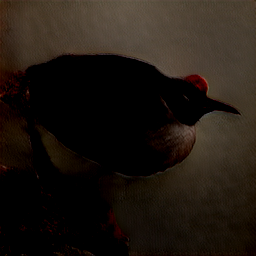

In [24]:
from PIL import Image
from IPython.display import display
img = Image.open('/content/StackGAN-v2-rev/code/embedding_output/gen_from_embedding_2.png')
display(img)
